In [1]:
from raid import run_detection, run_evaluation
from raid.utils import load_data

# Define your detector function
def my_detector(texts: list[str]) -> list[float]:
    pass

# Download & Load the RAID dataset
train_df = load_data(split="train")

# Run your detector on the dataset
predictions = run_detection(my_detector, train_df)

# Evaluate your detector predictions
evaluation_result = run_evaluation(predictions, train_df)


100%|██████████| 11.8G/11.8G [03:21<00:00, 58.6MB/s] 


ValueError: Predictions are missing outputs for human-written texts in some domains.
In order to run evaluation, you must include predictions for human-written data in all domains.
To disable this, set per_domain_tuning=False in run_evaluation.

textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

textattack: Downloading https://textattack.s3.amazonaws.com/word_embeddings/paragramcf.
100%|██████████| 481M/481M [01:26<00:00, 5.53MB/s] 
textattack: Unzipping file /root/.cache/textattack/tmpgzsgzcoz.zip to /root/.cache/textattack/word_embeddings/paragramcf.
textattack: Successfully saved word_embeddings/paragramcf to cache.
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertModel'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Generating adversarial examples...
Attack failed for text 0: 'Attack' object has no attribute 'goal'
Attack failed for text 1: 'Attack' object has no attribute 'goal'
Attack failed for text 2: 'Attack' object has no attribute 'goal'
Attack failed for text 3: 'Attack' object has no attribute 'goal'
Attack failed for text 4: 'Attack' object has no attribute 'goal'
Starting topological analysis...
Extracting representations from clean texts...
Extracting representations from adversarial texts...
Analyzing layer 3...
Analyzing layer 6...
Analyzing layer 9...
Analyzing layer 11...


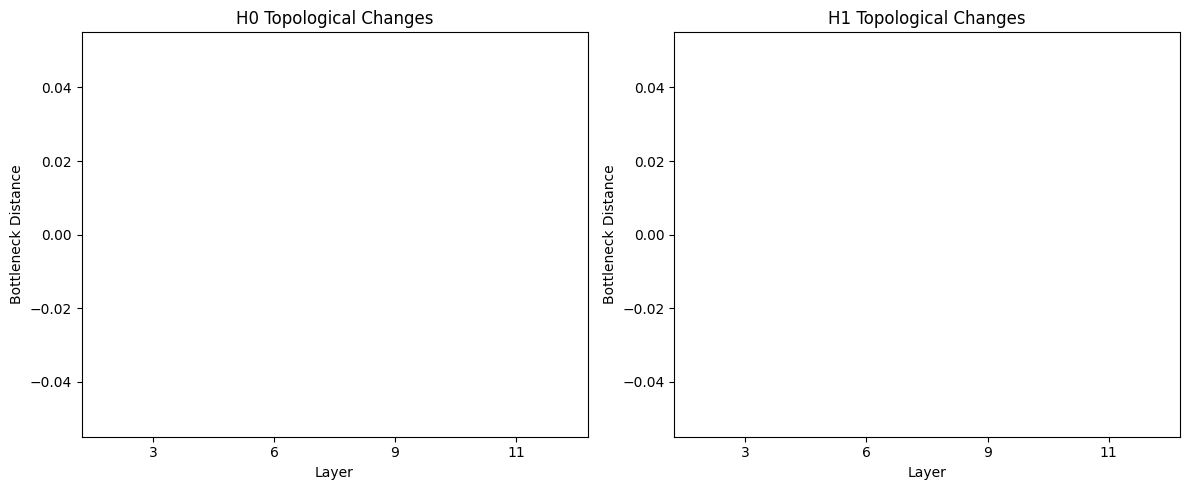

Analysis complete!


In [12]:
import torch
import numpy as np
from transformers import AutoModel, AutoTokenizer
import gudhi
from sklearn.metrics import pairwise_distances
from textattack.attack_recipes import TextFoolerJin2019
from textattack.datasets import HuggingFaceDataset
from textattack.models.wrappers import HuggingFaceModelWrapper
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import pickle

class TopologicalLLMAnalyzer:
    def __init__(self, model_name: str = "bert-base-uncased", device: str = "cuda"):
        """
        Initialize the analyzer with a pretrained LLM
        
        Args:
            model_name: HuggingFace model name
            device: Device to run on (cuda/cpu)
        """
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.model.eval()
        
        # Set up adversarial attack
        model_wrapper = HuggingFaceModelWrapper(self.model, self.tokenizer)
        self.attack = TextFoolerJin2019.build(model_wrapper)
        
    def extract_representations(self, texts: List[str], layers: List[int] = None) -> Dict[int, np.ndarray]:
        """
        Extract hidden representations from specified layers
        
        Args:
            texts: List of input texts
            layers: Which layers to extract (default: [6, 12, 18, 24] for large models)
            
        Returns:
            Dictionary mapping layer indices to representations
        """
        if layers is None:
            # Default to middle layers for analysis
            num_layers = self.model.config.num_hidden_layers
            layers = [num_layers//4, num_layers//2, 3*num_layers//4, num_layers-1]
        
        representations = {layer: [] for layer in layers}
        
        with torch.no_grad():
            for text in texts:
                # Tokenize input
                inputs = self.tokenizer(text, return_tensors="pt", 
                                      truncation=True, max_length=512).to(self.device)
                
                # Get model outputs with hidden states
                outputs = self.model(**inputs, output_hidden_states=True)
                hidden_states = outputs.hidden_states
                
                # Extract representations from specified layers
                for layer in layers:
                    # Use [CLS] token representation or mean pooling
                    layer_repr = hidden_states[layer][0, 0, :].cpu().numpy()  # [CLS] token
                    # Alternative: mean pooling
                    # layer_repr = hidden_states[layer][0].mean(dim=0).cpu().numpy()
                    representations[layer].append(layer_repr)
        
        # Convert to numpy arrays
        for layer in layers:
            representations[layer] = np.array(representations[layer])
            
        return representations
    
    def generate_adversarial_examples(self, texts: List[str], max_examples: int = 100) -> List[str]:
        """
        Generate adversarial examples using TextAttack
        
        Args:
            texts: Original texts
            max_examples: Maximum number of adversarial examples to generate
            
        Returns:
            List of adversarial texts
        """
        adversarial_texts = []
        
        for i, text in enumerate(texts[:max_examples]):
            try:
                # Create attack input
                attack_input = self.attack.goal.get_transformation().attack(text)
                if attack_input:
                    adversarial_texts.append(str(attack_input))
                else:
                    adversarial_texts.append(text)  # Fallback to original
            except Exception as e:
                print(f"Attack failed for text {i}: {e}")
                adversarial_texts.append(text)  # Fallback to original
                
        return adversarial_texts
    
    def compute_persistence_diagrams(self, representations: np.ndarray, 
                                   max_dimension: int = 1) -> List[Tuple]:
        """
        Compute persistence diagrams from representations
        
        Args:
            representations: Array of shape (n_samples, n_features)
            max_dimension: Maximum homology dimension to compute
            
        Returns:
            Persistence diagrams
        """
        # Compute pairwise distances
        distances = pairwise_distances(representations)
        
        # Create Rips complex
        rips_complex = gudhi.RipsComplex(distance_matrix=distances, max_edge_length=2.0)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dimension)
        
        # Compute persistence
        persistence = simplex_tree.persistence()
        
        return persistence
    
    def analyze_topological_changes(self, clean_texts: List[str], 
                                  adversarial_texts: List[str],
                                  layers: List[int] = None) -> Dict:
        """
        Main analysis function to compare topological features
        
        Args:
            clean_texts: Original texts
            adversarial_texts: Adversarially perturbed texts
            layers: Layers to analyze
            
        Returns:
            Dictionary containing analysis results
        """
        print("Extracting representations from clean texts...")
        clean_reps = self.extract_representations(clean_texts, layers)
        
        print("Extracting representations from adversarial texts...")
        adv_reps = self.extract_representations(adversarial_texts, layers)
        
        results = {}
        
        for layer in clean_reps.keys():
            print(f"Analyzing layer {layer}...")
            
            # Compute persistence diagrams
            clean_persistence = self.compute_persistence_diagrams(clean_reps[layer])
            adv_persistence = self.compute_persistence_diagrams(adv_reps[layer])
            
            # Extract 0-dimensional and 1-dimensional features
            clean_h0 = [(birth, death) for dim, (birth, death) in clean_persistence if dim == 0]
            clean_h1 = [(birth, death) for dim, (birth, death) in clean_persistence if dim == 1]
            adv_h0 = [(birth, death) for dim, (birth, death) in adv_persistence if dim == 0]
            adv_h1 = [(birth, death) for dim, (birth, death) in adv_persistence if dim == 1]
            
            # Compute bottleneck distances
            try:
                bottleneck_h0 = gudhi.bottleneck_distance(clean_h0, adv_h0)
                bottleneck_h1 = gudhi.bottleneck_distance(clean_h1, adv_h1) if clean_h1 and adv_h1 else 0.0
            except:
                bottleneck_h0, bottleneck_h1 = 0.0, 0.0
            
            results[layer] = {
                'clean_persistence': clean_persistence,
                'adv_persistence': adv_persistence,
                'bottleneck_distance_h0': bottleneck_h0,
                'bottleneck_distance_h1': bottleneck_h1,
                'clean_representations': clean_reps[layer],
                'adv_representations': adv_reps[layer]
            }
            
        return results
    
    def visualize_results(self, results: Dict, save_path: str = None):
        """
        Create visualizations of the topological analysis
        
        Args:
            results: Results from analyze_topological_changes
            save_path: Path to save the plot
        """
        layers = list(results.keys())
        h0_distances = [results[layer]['bottleneck_distance_h0'] for layer in layers]
        h1_distances = [results[layer]['bottleneck_distance_h1'] for layer in layers]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot H0 distances
        ax1.bar(range(len(layers)), h0_distances)
        ax1.set_xlabel('Layer')
        ax1.set_ylabel('Bottleneck Distance')
        ax1.set_title('H0 Topological Changes')
        ax1.set_xticks(range(len(layers)))
        ax1.set_xticklabels(layers)
        
        # Plot H1 distances
        ax2.bar(range(len(layers)), h1_distances)
        ax2.set_xlabel('Layer')
        ax2.set_ylabel('Bottleneck Distance')
        ax2.set_title('H1 Topological Changes')
        ax2.set_xticks(range(len(layers)))
        ax2.set_xticklabels(layers)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

# Example usage
def main():
    # Initialize analyzer
    analyzer = TopologicalLLMAnalyzer("bert-base-uncased")
    
    # Sample texts for analysis
    sample_texts = [
        "The quick brown fox jumps over the lazy dog.",
        "Machine learning is a subset of artificial intelligence.",
        "The stock market experienced significant volatility today.",
        "Climate change poses serious challenges for humanity.",
        "Technology continues to reshape our daily lives."
    ]
    
    # Generate adversarial examples
    print("Generating adversarial examples...")
    adversarial_texts = analyzer.generate_adversarial_examples(sample_texts)
    
    # Analyze topological changes
    print("Starting topological analysis...")
    results = analyzer.analyze_topological_changes(sample_texts, adversarial_texts)
    
    # Visualize results
    analyzer.visualize_results(results, "topological_analysis_results.png")
    
    # Save results
    with open("analysis_results.pkl", "wb") as f:
        pickle.dump(results, f)
    
    print("Analysis complete!")

if __name__ == "__main__":
    main()